In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from cliffs_delta import cliffs_delta
import os

sns.set_theme(style='whitegrid')

In [2]:
def get_data(folder):
    inf_times_cpu = pd.DataFrame()
    for f in os.listdir(os.path.join(folder, "logs")):
        if "cuda" not in f:
            file_list = f.split("_")
            job_num = file_list[-1]
            job_num = job_num.split(".")[0]
            if len(file_list) == 3:
                cat = file_list[1]
            else:
                cat = "base"
            for t in os.listdir(os.path.join(folder, "code", "saved_models", "times")):
                if job_num in t:
                    times = pd.read_csv(
                        os.path.join(folder, "code", "saved_models", "times", t),
                        header=None,
                    )
                    times.columns = [cat]
                    inf_times_cpu = pd.concat([inf_times_cpu, times], axis=1)
                    break
            for t in os.listdir(os.path.join(folder, "code", "saved_models_distil", "times")):
                if job_num in t:
                    times = pd.read_csv(
                        os.path.join(folder, "code", "saved_models_distil", "times", t),
                        header=None,
                    )
                    times.columns = [cat]
                    inf_times_cpu = pd.concat([inf_times_cpu, times], axis=1)
                    break

    cols = ["base", "distil", "quant4", "quant", "quantf8", "prune", "prune4", "prune6"]
    inf_times_cpu = inf_times_cpu[cols]
    inf_times_cuda = pd.DataFrame()
    for f in os.listdir(os.path.join(folder, "logs")):
        if "cuda" in f:
            file_list = f.split("_")
            job_num = file_list[-1]
            job_num = job_num.split(".")[0]
            if len(file_list) == 4:
                cat = file_list[2]
            else:
                cat = "base"
            for t in os.listdir(os.path.join(folder, "code", "saved_models", "times")):
                if job_num in t:
                    times = pd.read_csv(
                        os.path.join(folder, "code", "saved_models", "times", t),
                        header=None,
                    )
                    times.columns = [cat]
                    inf_times_cuda = pd.concat([inf_times_cuda, times], axis=1)
            for t in os.listdir(os.path.join(folder, "code", "saved_models_distil", "times")):
                if job_num in t:
                    times = pd.read_csv(
                        os.path.join(folder, "code", "saved_models_distil", "times", t),
                        header=None,
                    )
                    times.columns = [cat]
                    inf_times_cuda = pd.concat([inf_times_cuda, times], axis=1)

    # move columns
    cols = ["base", "distil", "quant4", "quant", "quantf8", "prune", "prune4", "prune6"]
    inf_times_cuda = inf_times_cuda[cols]
    return inf_times_cpu, inf_times_cuda


def get_stats(inf_times_cpu_cc):
    st = pd.DataFrame(
        [
            {
                "distil": stats.wilcoxon(
                    inf_times_cpu_cc["base"], inf_times_cpu_cc["distil"]
                )[1]/7,
                "quant4": stats.wilcoxon(
                    inf_times_cpu_cc["base"], inf_times_cpu_cc["quant4"]
                )[1]/7,
                "quant": stats.wilcoxon(
                    inf_times_cpu_cc["base"], inf_times_cpu_cc["quant"]
                )[1]/7,
                "quantf8": stats.wilcoxon(
                    inf_times_cpu_cc["base"], inf_times_cpu_cc["quantf8"]
                )[1]/7,
                "prune": stats.wilcoxon(
                    inf_times_cpu_cc["base"], inf_times_cpu_cc["prune"]
                )[1]/7,
                "prune4": stats.wilcoxon(
                    inf_times_cpu_cc["base"], inf_times_cpu_cc["prune4"]
                )[1]/7,
                "prune6": stats.wilcoxon(
                    inf_times_cpu_cc["base"], inf_times_cpu_cc["prune6"]
                )[1]/7,
            },
            {
                "distil": cliffs_delta(
                    inf_times_cpu_cc["base"], inf_times_cpu_cc["distil"]
                )[0],
                "quant4": cliffs_delta(
                    inf_times_cpu_cc["base"], inf_times_cpu_cc["quant4"]
                )[0],
                "quant": cliffs_delta(
                    inf_times_cpu_cc["base"], inf_times_cpu_cc["quant"]
                )[0],
                "quantf8": cliffs_delta(
                    inf_times_cpu_cc["base"], inf_times_cpu_cc["quantf8"]
                )[0],
                "prune": cliffs_delta(
                    inf_times_cpu_cc["base"], inf_times_cpu_cc["prune"]
                )[0],
                "prune4": cliffs_delta(
                    inf_times_cpu_cc["base"], inf_times_cpu_cc["prune4"]
                )[0],
                "prune6": cliffs_delta(
                    inf_times_cpu_cc["base"], inf_times_cpu_cc["prune6"]
                )[0],
            },
        ],
        index=["p-value", "delta"],
    )
    agg_st = inf_times_cpu_cc.describe().loc[["mean", "std", "50%"]]
    st = pd.concat([agg_st, st], axis=0)
    return st

def get_wstat(val1, val2):
    return stats.wilcoxon(val1, val2)

# Code-Code

In [3]:
inf_times_cpu_cc, inf_times_cuda_cc = get_data(os.path.join('..', "Code-Code", "Defect-detection"))

In [4]:
inf_times_cuda_cc.drop(0, inplace=True)

/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_12162/2985321189.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(


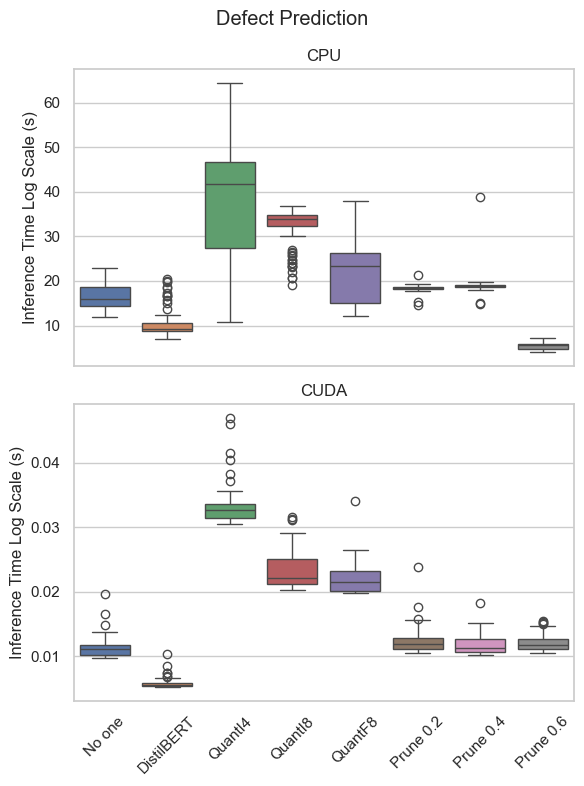

In [5]:
fig, ax = plt.subplots(2,1,figsize=(6, 8))
sns.boxplot(data=inf_times_cpu_cc, ax=ax[0])
ax[0].set_xticklabels('')
ax[0].set_ylabel("Inference Time Log Scale (s)")
ax[0].set_title("CPU")

sns.boxplot(data=inf_times_cuda_cc, ax=ax[1])
ax[1].set_xticklabels(
    [
        "No one",
        "DistilBERT",
        "QuantI4",
        "QuantI8",
        "QuantF8",
        "Prune 0.2",
        "Prune 0.4",
        "Prune 0.6",
    ],
    rotation=45,
)
ax[1].set_ylabel("Inference Time Log Scale (s)")
ax[1].set_title("CUDA")
fig.suptitle("Defect Prediction")
fig.tight_layout()
fig.savefig("imgs/inference_time_code_code.png", dpi=300)
plt.show()

In [5]:
cpu_stat = get_stats(inf_times_cpu_cc)
cuda_stat = get_stats(inf_times_cuda_cc)

In [6]:
cpu_stat

,base,distil,quant4,quant,quantf8,prune,prune4,prune6
mean,16.306010,1.048154e+01,3.767925e+01,3.224829e+01,2.258818e+01,1.839498e+01,1.896728e+01,5.381829e+00
std,2.520651,3.060149e+00,1.375795e+01,4.355248e+00,7.576861e+00,7.295515e-01,2.275204e+00,6.427328e-01
50%,15.902356,9.122519e+00,4.168345e+01,3.389789e+01,2.337324e+01,1.838060e+01,1.882870e+01,5.585062e+00
p-value,NaN,9.194100e-15,1.468810e-15,1.182180e-16,1.517149e-09,5.569036e-10,3.201988e-12,1.141300e-16
delta,NaN,8.196322e-01,-7.736614e-01,-9.956733e-01,-4.583559e-01,-4.572742e-01,-5.786912e-01,1.000000e+00


In [7]:
cuda_stat

,base,distil,quant4,quant,quantf8,prune,prune4,prune6
mean,0.011219,5.782997e-03,3.314674e-02,2.328622e-02,2.198351e-02,1.229706e-02,1.185350e-02,1.200015e-02
std,0.001494,7.475471e-04,2.854676e-03,2.629588e-03,2.199123e-03,1.902336e-03,1.490512e-03,1.232276e-03
50%,0.011143,5.574703e-03,3.272414e-02,2.215910e-02,2.145362e-02,1.187062e-02,1.133776e-02,1.172328e-02
p-value,NaN,1.670006e-16,1.670006e-16,1.670006e-16,1.670006e-16,3.615679e-11,9.604887e-07,3.769651e-10
delta,NaN,9.908651e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-4.765398e-01,-3.428374e-01,-4.444291e-01


In [22]:
get_wstat(inf_times_cpu_cc["quant4"], inf_times_cpu_cc["quant"])

WilcoxonResult(statistic=1028.0, pvalue=0.00028584386093005016)

In [23]:
get_wstat(inf_times_cpu_cc["quant4"], inf_times_cpu_cc["quantf8"])

WilcoxonResult(statistic=365.0, pvalue=9.010843743625621e-11)

In [24]:
get_wstat(inf_times_cpu_cc["prune"], inf_times_cpu_cc["prune4"])

WilcoxonResult(statistic=683.0, pvalue=3.1645927122926934e-07)

## Code-Text

In [8]:
inf_times_cpu_ct = pd.DataFrame()
for f in os.listdir(os.path.join('../Code-Text/code-to-text', "logs")):
    if "cuda" not in f:
        file_list = f.split("_")
        job_num = file_list[-1]
        job_num = job_num.split(".")[0]
        if len(file_list) == 3:
            cat = file_list[1]
        else:
            cat = "base"
        for t in os.listdir(
            os.path.join("../Code-Text/code-to-text", "code/model/java", "times")
        ):
            if job_num in t:
                times = pd.read_csv(
                    os.path.join(
                        "../Code-Text/code-to-text", "code/model/java", "times", t
                    ),
                    header=None,
                ).T
                times.columns = [cat]
                inf_times_cpu_ct = pd.concat([inf_times_cpu_ct, times], axis=1)
                break
        for t in os.listdir(
            os.path.join("../Code-Text/code-to-text", "code/model_distilbert/java", "times")
        ):
            if job_num in t:
                times = pd.read_csv(
                    os.path.join(
                        "../Code-Text/code-to-text", "code/model_distilbert/java", "times", t
                    ),
                    header=None,
                ).T
                times.columns = [cat]
                inf_times_cpu_ct = pd.concat([inf_times_cpu_ct, times], axis=1)
                break

cols = ["base", "distil", "quant4", "quant", "quantf8", "prune", "prune4", "prune6"]
inf_times_cpu_ct = inf_times_cpu_ct[cols]
inf_times_cuda_ct = pd.DataFrame()
for f in os.listdir(os.path.join("../Code-Text/code-to-text", "logs")):
    if "cuda" in f:
        file_list = f.split("_")
        job_num = file_list[-1]
        job_num = job_num.split(".")[0]
        if len(file_list) == 4:
            cat = file_list[2]
        else:
            cat = "base"
        for t in os.listdir(
            os.path.join("../Code-Text/code-to-text", "code/model/java", "times")
        ):
            if job_num in t:
                times = pd.read_csv(
                    os.path.join(
                        "../Code-Text/code-to-text", "code/model/java", "times", t
                    ),
                    header=None,
                ).T
                times.columns = [cat]
                inf_times_cuda_ct = pd.concat([inf_times_cuda_ct, times], axis=1)
        for t in os.listdir(
            os.path.join("../Code-Text/code-to-text", "code/model_distilbert/java", "times")
        ):
            if job_num in t:
                times = pd.read_csv(
                    os.path.join(
                        "../Code-Text/code-to-text", "code/model_distilbert/java", "times", t
                    ),
                    header=None,
                ).T
                times.columns = [cat]
                inf_times_cuda_ct = pd.concat([inf_times_cuda_ct, times], axis=1)

# move columns
cols = ["base", "distil", "quant4", "quant", "quantf8", "prune", "prune4", "prune6"]
inf_times_cuda_ct = inf_times_cuda_ct[cols]
inf_times_cpu_ct.dropna(inplace=True)
inf_times_cuda_ct.dropna(inplace=True)

/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_12162/4234883554.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(


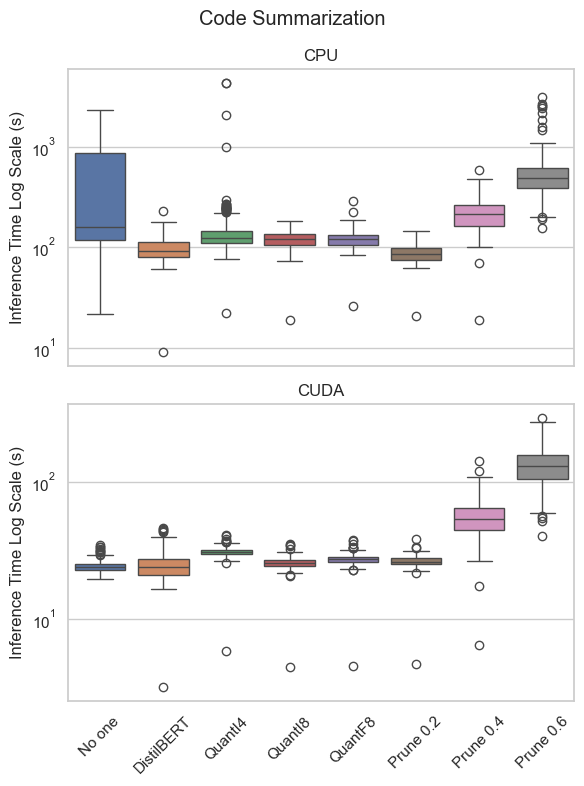

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
sns.boxplot(data=inf_times_cpu_ct, ax=ax[0],log_scale=True)
ax[0].set_xticklabels("")
ax[0].set_ylabel("Inference Time Log Scale (s)")
# ax[0].set_ylim(0, 2100)
ax[0].set_title("CPU")

sns.boxplot(data=inf_times_cuda_ct, ax=ax[1],log_scale=True)
ax[1].set_xticklabels(
    [
        "No one",
        "DistilBERT",
        "QuantI4",
        "QuantI8",
        "QuantF8",
        "Prune 0.2",
        "Prune 0.4",
        "Prune 0.6",
    ],
    rotation=45,
)
ax[1].set_ylabel("Inference Time Log Scale (s)")
ax[1].set_title("CUDA")
fig.suptitle("Code Summarization")
fig.tight_layout()
fig.savefig("imgs/inference_time_code_text.png", dpi=300)
plt.show()

In [9]:
stats_cpu = get_stats(inf_times_cpu_ct)
stats_cuda = get_stats(inf_times_cuda_ct)

In [10]:
stats_cpu

,base,distil,quant4,quant,quantf8,prune,prune4,prune6
mean,500.380324,9.922454e+01,2.013017e+02,1.210126e+02,1.210395e+02,8.820054e+01,225.061078,597.948753
std,607.318997,2.952769e+01,4.744770e+02,2.259443e+01,2.537503e+01,1.792506e+01,82.599278,446.601389
50%,157.368780,9.206538e+01,1.226018e+02,1.207661e+02,1.198241e+02,8.580906e+01,214.042914,484.378003
p-value,NaN,2.548238e-24,3.449084e-09,1.068141e-20,3.129619e-15,2.720816e-30,0.029202,0.001032
delta,NaN,7.439832e-01,3.404543e-01,4.600460e-01,4.829638e-01,8.735127e-01,-0.170971,-0.456531


In [11]:
stats_cuda

,base,distil,quant4,quant,quantf8,prune,prune4,prune6
mean,24.246838,25.044208,3.067347e+01,2.546679e+01,2.724867e+01,2.629795e+01,5.681934e+01,1.335080e+02
std,2.602540,6.042229,3.044413e+00,2.796149e+00,2.938724e+00,2.729052e+00,1.918258e+01,4.628012e+01
50%,23.691545,23.841240,3.041913e+01,2.530500e+01,2.712745e+01,2.606430e+01,5.324998e+01,1.290006e+02
p-value,NaN,0.063640,6.066243e-29,1.715053e-08,2.186888e-20,8.990586e-16,2.286913e-30,8.024833e-31
delta,NaN,0.048607,-8.989319e-01,-3.998107e-01,-6.861141e-01,-5.809897e-01,-9.724851e-01,-1.000000e+00


## Text-Code

In [20]:
inf_times_cpu_tc = pd.DataFrame()
for f in os.listdir(os.path.join("../Text-Code/NL-code-search", "logs")):
    if "nocuda" in f:
        file_list = f.split("_")
        job_num = file_list[-1]
        job_num = job_num.split(".")[0]
        if len(file_list) == 4:
            cat = file_list[1]
        else:
            cat = "base"
        for t in os.listdir(
            os.path.join("../Text-Code/NL-code-search", "code/saved_models", "times")
        ):
            if job_num in t:
                times = pd.read_csv(
                    os.path.join(
                        "../Text-Code/NL-code-search", "code/saved_models", "times", t
                    ),
                    header=None,
                )
                times.columns = [cat]
                inf_times_cpu_tc = pd.concat([inf_times_cpu_tc, times], axis=1)
                break

        for t in os.listdir(
            os.path.join("../Text-Code/NL-code-search", "code/saved_models_distil", "times")
        ):
            if job_num in t:
                times = pd.read_csv(
                    os.path.join(
                        "../Text-Code/NL-code-search", "code/saved_models_distil", "times", t
                    ),
                    header=None,
                )
                times.columns = [cat]
                inf_times_cpu_tc = pd.concat([inf_times_cpu_tc, times], axis=1)
                break

cols = ["base", "distil", "quant4", "quant", "quantf8", "prune", "prune4", "prune6"]
inf_times_cpu_tc = inf_times_cpu_tc[cols]
inf_times_cuda_tc = pd.DataFrame()
for f in os.listdir(os.path.join("../Text-Code/NL-code-search", "logs")):
    if "nocuda" not in f:
        file_list = f.split("_")
        job_num = file_list[-1]
        job_num = job_num.split(".")[0]
        if len(file_list) == 3:
            cat = file_list[1]
        else:
            cat = "base"
        for t in os.listdir(
            os.path.join("../Text-Code/NL-code-search", "code/saved_models", "times")
        ):
            if job_num in t:
                times = pd.read_csv(
                    os.path.join(
                        "../Text-Code/NL-code-search", "code/saved_models", "times", t
                    ),
                    header=None,
                )
                times.columns = [cat]
                inf_times_cuda_tc = pd.concat([inf_times_cuda_tc, times], axis=1)
        for t in os.listdir(
            os.path.join("../Text-Code/NL-code-search", "code/saved_models_distil", "times")
        ):
            if job_num in t:
                times = pd.read_csv(
                    os.path.join(
                        "../Text-Code/NL-code-search", "code/saved_models_distil", "times", t
                    ),
                    header=None,
                )
                times.columns = [cat]
                inf_times_cuda_tc = pd.concat([inf_times_cuda_tc, times], axis=1)

# move columns
cols = ["base", "distil", "quant4", "quant", "quantf8", "prune", "prune4", "prune6"]
inf_times_cuda_tc = inf_times_cuda_tc[cols]
inf_times_cpu_tc.dropna(inplace=True)
inf_times_cuda_tc.dropna(inplace=True)

/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_73553/3852801531.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(


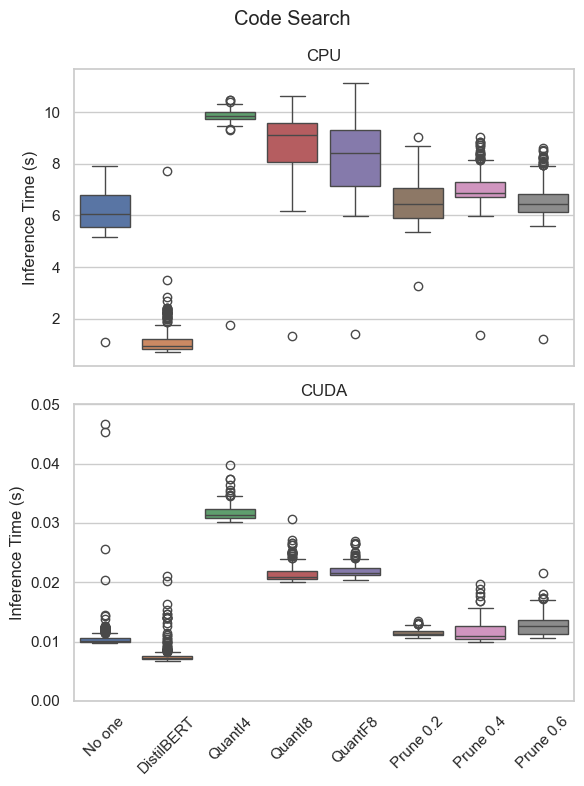

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
sns.boxplot(data=inf_times_cpu_tc, ax=ax[0])
ax[0].set_xticklabels("")
ax[0].set_ylabel("Inference Time (s)")
ax[0].set_title("CPU")

sns.boxplot(data=inf_times_cuda_tc, ax=ax[1])
ax[1].set_xticklabels(
    [
        "No one",
        "DistilBERT",
        "QuantI4",
        "QuantI8",
        "QuantF8",
        "Prune 0.2",
        "Prune 0.4",
        "Prune 0.6",
    ],
    rotation=45,
)
ax[1].set_ylabel("Inference Time (s)")
ax[1].set_title("CUDA")
ax[1].set_ylim(0, 0.05)
fig.suptitle("Code Search")
fig.tight_layout()
fig.savefig("imgs/inference_time_text_code.png", dpi=300)
plt.show()

In [22]:
stats_cpu = get_stats(inf_times_cpu_tc)
stats_cuda = get_stats(inf_times_cuda_tc)

In [23]:
stats_cpu

,base,distil,quant4,quant,quantf8,prune,prune4,prune6
mean,6.178660,1.141790e+00,9.853986e+00,8.726290e+00,8.263458e+00,6.528729e+00,7.098404e+00,6.581949e+00
std,0.739632,6.202258e-01,5.043801e-01,1.234711e+00,1.208050e+00,7.798340e-01,6.722890e-01,7.074211e-01
50%,6.046950,9.183624e-01,9.874065e+00,9.115803e+00,8.411494e+00,6.449886e+00,6.875338e+00,6.449681e+00
p-value,NaN,6.083645e-52,5.963259e-52,2.312910e-50,6.415922e-50,3.726381e-17,2.489056e-39,1.962795e-07
delta,NaN,9.915453e-01,-9.933776e-01,-8.905752e-01,-8.645710e-01,-2.815311e-01,-6.251697e-01,-3.027560e-01


In [24]:
stats_cuda

,base,distil,quant4,quant,quantf8,prune,prune4,prune6
mean,0.014026,7.789292e-03,3.171536e-02,2.138886e-02,2.205197e-02,1.149526e-02,1.162474e-02,1.275525e-02
std,0.019842,1.875772e-03,1.297569e-03,1.434603e-03,2.984043e-03,5.886990e-04,1.623325e-03,1.645566e-03
50%,0.010074,7.190943e-03,3.138971e-02,2.079606e-02,2.161789e-02,1.129079e-02,1.092720e-02,1.259446e-02
p-value,NaN,9.647821e-42,5.849998e-40,9.550561e-38,9.233202e-38,5.190321e-26,8.876314e-19,4.558242e-33
delta,NaN,8.732354e-01,-9.202658e-01,-9.130032e-01,-9.138199e-01,-6.499376e-01,-6.014503e-01,-7.703557e-01


# Percentage Variations

## Inference Time

In [36]:
def make_plot(inf_times, title, col="device", fig_name="", y_lim=None):
    if fig_name=="":
        fig_name = title
    g = sns.FacetGrid(
        inf_times, col=col, hue="variable", height=4, ylim=y_lim
    )
    g.map(sns.barplot, "variable", "value")
    g.set_ylabels("Percentage variation (%)")
    g.set_xlabels("")
    g.set_titles("{col_name}")
    g.set_xticklabels(
        [
            "DistilBERT",
            "QuantI4",
            "QuantI8",
            "QuantF8",
            "Prune 0.2",
            "Prune 0.4",
            "Prune 0.6",
        ],
        rotation=45,
    )
    for ax in g.axes.flat:
        for p in ax.patches:
            if p.get_height() > 0.0:
                ax.annotate(
                    f"{p.get_height():.2f}",
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha="center",
                    va="center",
                    xytext=(0, 5),
                    textcoords="offset points",
                )
            if p.get_height() <= 0.0:
                ax.annotate(
                    f"{p.get_height():.2f}",
                    (p.get_x() + p.get_width() / 2, p.get_height()-35),
                    ha="center",
                    va="center",
                    xytext=(0, 5),
                    textcoords="offset points",
                )
    g.figure.suptitle(title)
    g.figure.tight_layout()
    g.savefig(f"imgs/{fig_name}.png", dpi=300)
    plt.show()

In [37]:
inf_times = pd.DataFrame(
    [
        {
            "distil": -41.26,
            "quant4": 133.04,
            "quant8": 103.79,
            "quantf8": 64.01,
            "prune2": 19.51,
            "prune4": 21.86,
            "prune6": -62.28,
            "task": "Code-Code",
            "device": "CPU (Base Avg Time 15.439)",
        },
        {
            "distil": -47.48,
            "quant4": 190.83,
            "quant8": 85.96,
            "quantf8": 100.86,
            "prune2": 36.92,
            "prune4": 4.97,
            "prune6": 6.92,
            "task": "Code-Code",
            "device": "CUDA (Base Avg Time 0.01)",
        },
    ],
)
inf_times = pd.melt(inf_times, id_vars=["task", "device"])

/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_12355/3741112970.py:44: UserWarning: The figure layout has changed to tight
  g.figure.tight_layout()


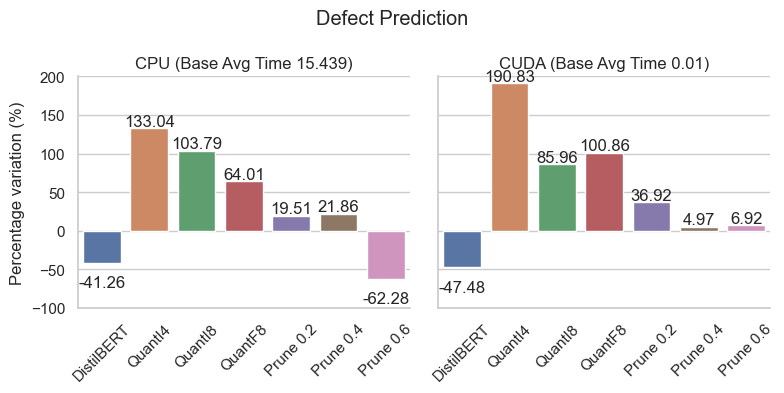

In [38]:
make_plot(inf_times, "Defect Prediction", y_lim=(-100, 200))

In [39]:
inf_times_code_text = pd.DataFrame(
    [
        {
            "distil": -80.17,
            "quant4": -59.77,
            "quant8": -75.82,
            "quantf8": -75.81,
            "prune2": -82.37,
            "prune4": -55.02,
            "prune6": 19.50,
            "task": "Code-Text",
            "device": "CPU (Base Avg Time 500.380)",
        },
        {
            "distil": 5.58,
            "quant4": 29.31,
            "quant8": 7.36,
            "quantf8": 14.87,
            "prune2": 10.86,
            "prune4": 139.53,
            "prune6": 462.83,
            "task": "Code-Text",
            "device": "CUDA (Base Avg Time 23.721)",
        },
    ]
)
inf_times_code_text = pd.melt(inf_times_code_text, id_vars=["task", 'device'])

/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_12355/3741112970.py:44: UserWarning: The figure layout has changed to tight
  g.figure.tight_layout()


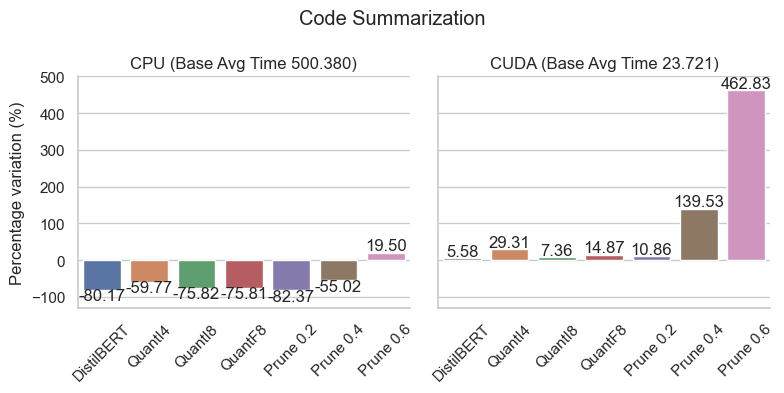

In [40]:
make_plot(inf_times_code_text, "Code Summarization", y_lim=(-130, 500))

In [41]:
inf_times_text_code = pd.DataFrame(
    [
        {
            "distil": -81.52,
            "quant4": 59.48,
            "quant8": 41.23,
            "quantf8": 33.74,
            "prune2": 5.67,
            "prune4": 14.89,
            "prune6": 6.53,
            "task": "Text-Code",
            "device": "CPU (Base Avg Time 6.179)",
        },
        {
            "distil": -57.62,
            "quant4": 126.11,
            "quant8": 48.19,
            "quantf8": 57.22,
            "prune2": -18.05,
            "prune4": -17.12,
            "prune6": -9.06,
            "task": "Text-Code",
            "device": "CUDA (Base Avg Time 0.014)",
        },
    ]
)
inf_times_text_code= pd.melt(inf_times_text_code, id_vars=["task", "device"])

/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_12355/3741112970.py:44: UserWarning: The figure layout has changed to tight
  g.figure.tight_layout()


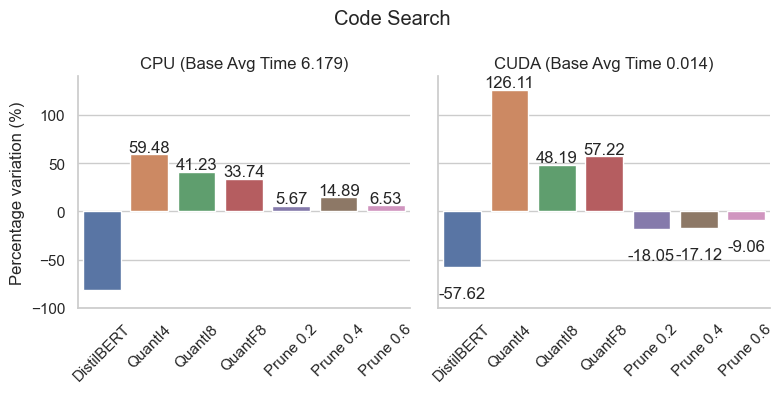

In [42]:
make_plot(inf_times_text_code, "Code Search", y_lim=(-100, 140))

## Model Size

In [43]:
inf_times = pd.DataFrame(
    [
        {
            "distil": -48.77,
            "quant4": -59.32,
            "quant8": -51.36,
            "quantf8": -51.36,
            "prune2": 0.00,
            "prune4": 0.00,
            "prune6": 0.00,
            "task": "Defect Pred. (Base Size 498.65 MB)",
        },
        {
            "distil": -32.98,
            "quant4": -51.89,
            "quant8": -41.98,
            "quantf8": -41.98,
            "prune2": 0.00,
            "prune4": 0.00,
            "prune6": 0.00,
            "task": "Code Summ. (Base Size 706.91 MB)",
        },
        {
            "distil": -48.75,
            "quant4": -59.33,
            "quant8": -51.36,
            "quantf8": -51.36,
            "prune2": 0.00,
            "prune4": 0.00,
            "prune6": 0.00,
            "task": "Code Search (Base Size 498.64 MB)",
        },
    ],
)
inf_times = pd.melt(inf_times, id_vars=["task"])

/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_12355/3741112970.py:44: UserWarning: The figure layout has changed to tight
  g.figure.tight_layout()


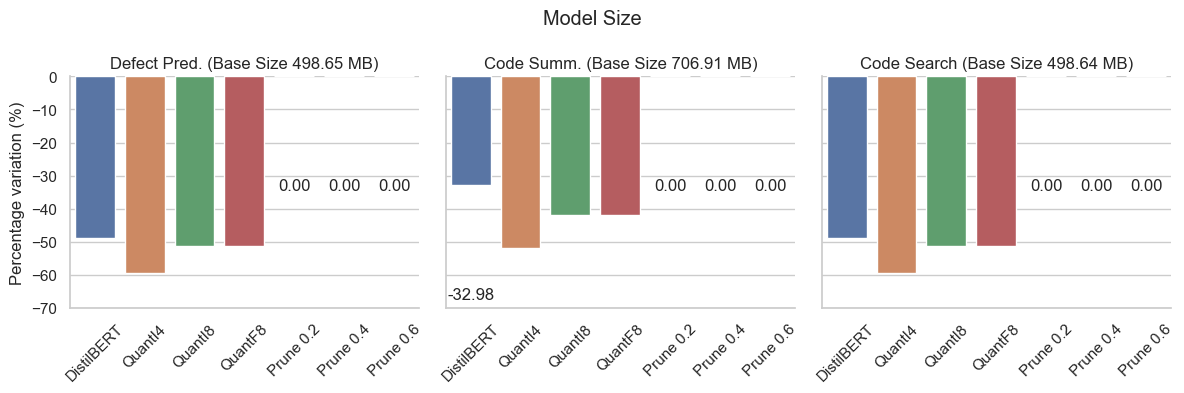

In [44]:
make_plot(inf_times, "Model Size", col="task", fig_name="model_size", y_lim=(-70, 0))

## Effectiveness

In [45]:
inf_times = pd.DataFrame(
    [
        {
            "distil": -2.15,
            "quant4": -1.57,
            "quant8": -0.41,
            "quantf8": 0.06,
            "prune2": -4.30,
            "prune4": -7.21,
            "prune6": -5.76,
            "task": "Defect Pred. (Base Acc 0.63)",
        },
        {
            "distil": -42.30,
            "quant4": -2.04,
            "quant8": -41.98,
            "quantf8": 0.43,
            "prune2": -4.29,
            "prune4": -66.64,
            "prune6": -93.35,
            "task": "Code Summ. (Base BLEU 18.791)",
        },
        {
            "distil": -52.35,
            "quant4": -6.32,
            "quant8": 0.00,
            "quantf8": -0.21,
            "prune2": -3.22,
            "prune4": -52.11,
            "prune6": -99.57,
            "task": "Code Search (Base MRR 0.329)",
        },
    ],
)
inf_times = pd.melt(inf_times, id_vars=["task"])

/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/giord/miniconda3/envs/bias/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/4c/mgvn0dc97_9gst9l7jbv9n640000gn/T/ipykernel_12355/3741112970.py:44: UserWarning: The figure layout has changed to tight
  g.figure.tight_layout()


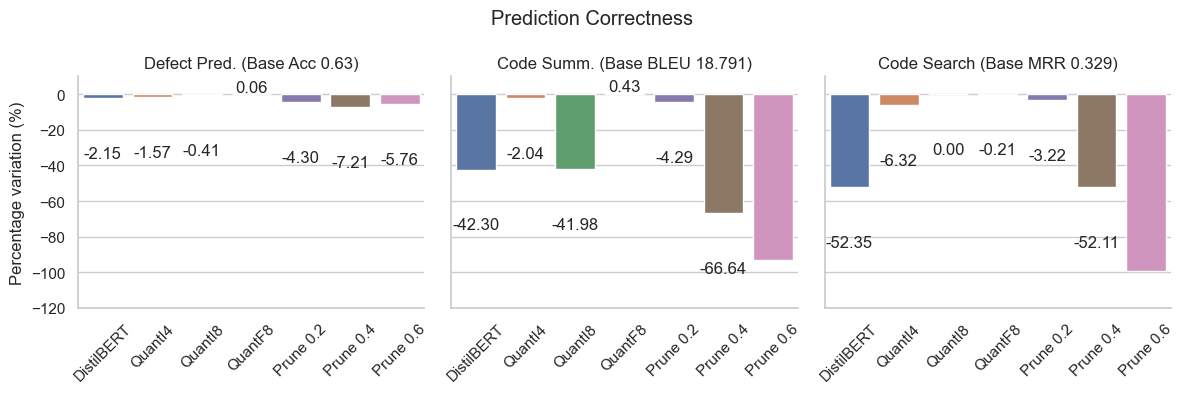

In [46]:
make_plot(inf_times, "Prediction Correctness", col="task", fig_name="model_corr", y_lim=(-120, 10))